## Pre-Processing and Data Loader

In [9]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor,Resize,Normalize
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

In [1]:
!pip install pandas

In [3]:
import pandas as pd

In [82]:
#constant values on normalize - ImageNet Parameters (mean and std)
#ToTensor() - GPU, Resize - Transform your image to ImageNet readable format
transformer = transforms.Compose([Resize((224,224)),
                                 ToTensor(),
                                 Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

In [5]:
train_data=ImageFolder(root=os.path.join(os.getcwd(),'train/train'), 
                       transform=transformer)

Text(0.5, 1.0, '0')

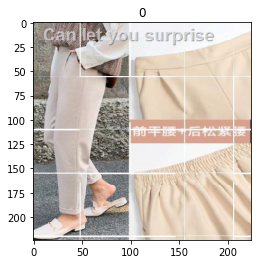

In [6]:
sample_img = train_data[2][0].numpy().transpose(1,2,0)
mean = np.array([0.485,0.456,0.406])
std = np.array([0.229,0.224, 0.225])
inp = std*sample_img+mean
inp = np.clip(inp,0,1)
plt.imshow(inp)
plt.title(train_data[0][1])

In [7]:
dataloader = DataLoader(train_data, batch_size=4,
                        shuffle=True, num_workers=4)

In [121]:
mask = np.random.choice(len(train_data)-1,3000)
train_len = int(0.7*3000)
trainset = torch.utils.data.Subset(train_data, mask)
dataloaders = {}
tempdl = {}
tempdl['train'],tempdl['val'] = torch.utils.data.random_split(trainset, [train_len,3000-train_len])

dataloaders['train'] = torch.utils.data.DataLoader(tempdl['train'],batch_size=4,shuffle=True,num_workers=4)
dataloaders['val']= torch.utils.data.DataLoader(tempdl['val'],batch_size=4,shuffle=True,num_workers=4)

Visualize Images

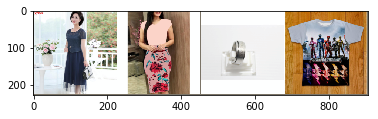

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## Pre-Trained Model Experimentation

In [ ]:
from torchvision import models
import torch

In [ ]:
resnet18_model = models.resnet101(pretrained=True)

In [ ]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, 100), display_id=True)
for ii in range(101):
    time.sleep(0.02)
    out.update(progress(ii, 100))

In [ ]:
%%time
idx = 0
res = pd.DataFrame()
for i in np.random.choice(len(train_data),1000):
    probs = resnet18_model(torch.unsqueeze(train_data[i][0],0))
    value, index = torch.max(probs,1)
    res.loc[idx,'preds']=index.numpy()[0]
    res.loc[idx,'conf']=value.detach().numpy()[0]
    res.loc[idx,'actuals']=train_data[i][1]

    idx+=1
    out.update(progress(idx, 1000))

In [ ]:
df_all = res.groupby(['preds','actuals']).count().reset_index()

In [ ]:
res.groupby('preds').count()

In [ ]:
df_all

In [ ]:
df_mapping = df_all.groupby('preds').max()/df_all.groupby('preds').sum()
df_mapping = df_mapping.reset_index()

In [ ]:
df_all

In [ ]:
def find_val(x):
    current = df_all[df_all['preds']==x].reset_index(drop=True)
    mx = current.sort_values('conf',ascending=False)
    try:
        return current['actuals'].iloc[0]
    except:
        return 3

In [ ]:
df_mapping['map_to'] = df_mapping['preds'].apply(lambda x: find_val(x))

In [ ]:
df_mapping

In [ ]:
test_transforms = transforms.Compose([Resize((224,224)),
                                 ToTensor(),
                                 Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
test_data=ImageFolder(root=os.path.join(os.getcwd(),'test/test'), 
                       transform=transforms)

## Actually Train the Model

In [12]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [123]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (4*len(dataloaders[phase]))
            epoch_acc = running_corrects.double() / (4*len(dataloaders[phase]))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Evaluate Results

In [126]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 42)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [127]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=3)

Epoch 0/2
----------
train Loss: 3.1933 Acc: 0.1838
val Loss: 2.1021 Acc: 0.4156

Epoch 1/2
----------
train Loss: 2.1300 Acc: 0.4290
val Loss: 2.0222 Acc: 0.4778

Epoch 2/2
----------
train Loss: 1.5016 Acc: 0.5781
val Loss: 1.9584 Acc: 0.5322

Training complete in 22m 2s
Best val Acc: 0.532222


In [83]:
path = os.path.join(os.getcwd()+"\\test")
test_data = torchvision.datasets.ImageFolder(path, transform=transformer)

In [90]:
test_loader = DataLoader(test_data, batch_size=1, num_workers=4)

In [40]:
arr = []
for i,j in test_data.imgs:
    arr.append(i.split('\\')[-1])

In [128]:
ans = pd.DataFrame()
model_ft.eval()
idx=0

for inputs,_ in test_loader:
    inputs = inputs.to(device)
    
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    ans.loc[idx,'filename'] = arr[idx]
    ans.loc[idx,'preds'] = preds.numpy()[0]
    out.update(progress(idx, 12000))
    idx+=1

In [91]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

out = display(progress(0, 100), display_id=True)
for ii in range(101):
    time.sleep(0.02)
    out.update(progress(ii, 100))

In [129]:
ans.groupby('preds').count()

,filename
preds,
0.0,30
1.0,411
2.0,596
3.0,179
4.0,316
5.0,169
6.0,343
7.0,231
8.0,182


In [131]:
valid_fn = pd.read_csv('test.csv')['filename']

In [132]:
ans_final = ans[ans['filename'].isin(valid_fn)].reset_index(drop=True)

In [133]:
ans_final['category'] = np.where(ans_final['preds']<10,'0'+ans_final['preds'].astype(int).astype(str),
                                 ans_final['preds'].astype(int).astype(str))

In [134]:
ans_final[['filename','category']].to_csv('results1.csv',index=False)